In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import QuantileTransformer

In [3]:
url='https://raw.githubusercontent.com/digipodium/Datasets/main/regression/diamonds.csv'

In [4]:
df = pd.read_csv(url, index_col=0)
df

carat        cut color clarity  depth  table  price     x     y     z
1       0.23      Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
2       0.21    Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
3       0.23       Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
4       0.29    Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
5       0.31       Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75
...      ...        ...   ...     ...    ...    ...    ...   ...   ...   ...
53936   0.72      Ideal     D     SI1   60.8   57.0   2757  5.75  5.76  3.50
53937   0.72       Good     D     SI1   63.1   55.0   2757  5.69  5.75  3.61
53938   0.70  Very Good     D     SI1   62.8   60.0   2757  5.66  5.68  3.56
53939   0.86    Premium     H     SI2   61.0   58.0   2757  6.15  6.12  3.74
53940   0.75      Ideal     D     SI2   62.2   55.0   2757  5.83  5.87  3.64

[53940 rows x 10 columns]

In [5]:
df.describe()

carat         depth         table         price             x  \
count  53940.000000  53940.000000  53940.000000  53940.000000  53940.000000   
mean       0.797940     61.749405     57.457184   3932.799722      5.731157   
std        0.474011      1.432621      2.234491   3989.439738      1.121761   
min        0.200000     43.000000     43.000000    326.000000      0.000000   
25%        0.400000     61.000000     56.000000    950.000000      4.710000   
50%        0.700000     61.800000     57.000000   2401.000000      5.700000   
75%        1.040000     62.500000     59.000000   5324.250000      6.540000   
max        5.010000     79.000000     95.000000  18823.000000     10.740000   

                  y             z  
count  53940.000000  53940.000000  
mean       5.734526      3.538734  
std        1.142135      0.705699  
min        0.000000      0.000000  
25%        4.720000      2.910000  
50%        5.710000      3.530000  
75%        6.540000      4.040000  
max       58.900000     31.800000

# handling skewness

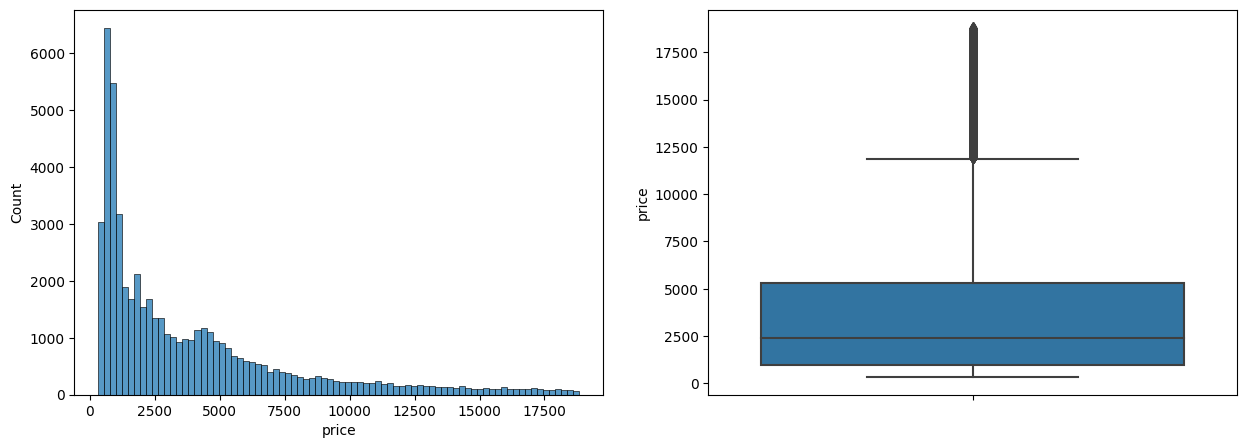

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
sns.histplot(data=df, x = 'price', ax=ax[0])
sns.boxplot(data=df, y = 'price', ax=ax[1])
plt.show()

In [7]:
X = df.drop('price', axis=1)
y = df['price']

# transform the y to log scale
y = np.log1p(y) # this log1p will remove the skewness of the data and make it more normal distribution for better prediction

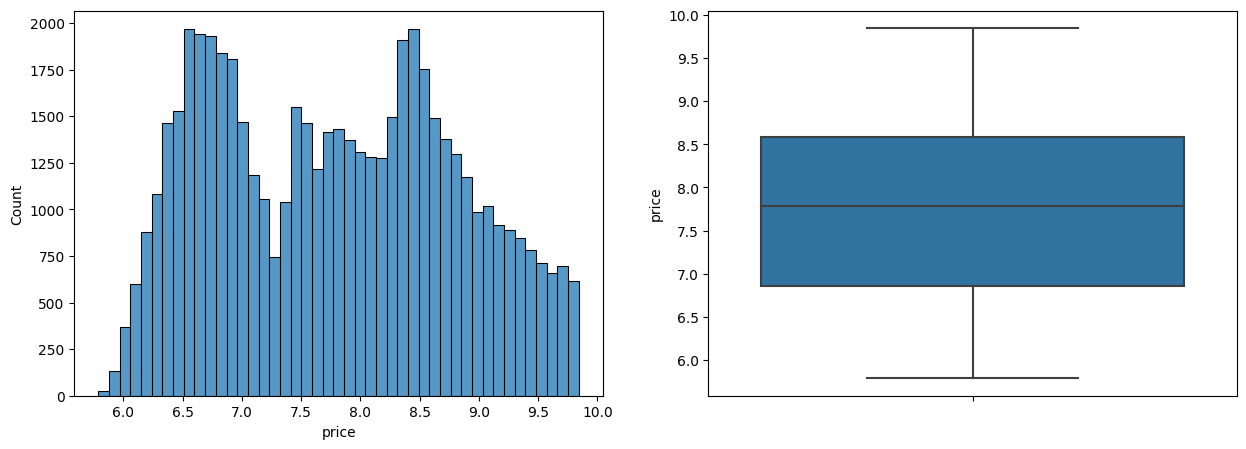

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
sns.histplot(x = y, ax=ax[0])
sns.boxplot(y = y, ax=ax[1])
plt.show()

In [9]:
y = df['price']
qt = QuantileTransformer()
y_trans = qt.fit_transform(y.values.reshape(-1,1)).flatten()

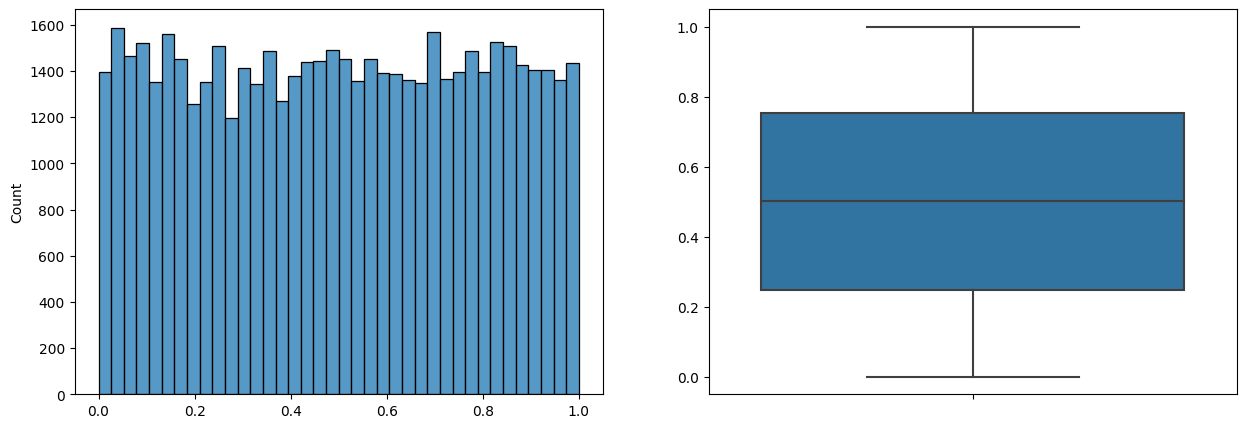

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
sns.histplot(x = y_trans, ax=ax[0])
sns.boxplot(y = y_trans, ax=ax[1])
plt.show()

back to model pipeline creation

In [11]:
X = df.drop('price', axis=1)
y = df['price']

In [12]:
cat_cols = df.select_dtypes(exclude='number').columns
num_cols = df.select_dtypes('number').columns
num_cols = num_cols.drop('price')
print(cat_cols)
print(num_cols)

Index(['cut', 'color', 'clarity'], dtype='object')
Index(['carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object')


In [13]:
cat_pipe = Pipeline([('oe', OrdinalEncoder())])
num_pipe = Pipeline([('sc', StandardScaler())])
transformer = ColumnTransformer([
    ('categorical', cat_pipe, cat_cols),
    ('numerical', num_pipe, num_cols),
])
transformer

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('oe', OrdinalEncoder())]),
                                 Index(['cut', 'color', 'clarity'], dtype='object')),
                                ('numerical',
                                 Pipeline(steps=[('sc', StandardScaler())]),
                                 Index(['carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object'))])

In [14]:
model_pipe = Pipeline([
    ('transformer', transformer),
    ('model', RandomForestRegressor(max_depth=10))
])
model_pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('oe',
                                                                   OrdinalEncoder())]),
                                                  Index(['cut', 'color', 'clarity'], dtype='object')),
                                                 ('numerical',
                                                  Pipeline(steps=[('sc',
                                                                   StandardScaler())]),
                                                  Index(['carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object'))])),
                ('model', RandomForestRegressor(max_depth=10))])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y_trans, test_size=0.2, random_state=42)
model_pipe.fit(X_train, y_train)
y_pred = model_pipe.predict(X_test)
# metrics
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))

MAE: 0.024328967523498828
MSE: 0.001065932480652285


In [16]:
print("score", r2_score(y_test, y_pred))

score 0.9873594998169654


In [17]:
result = model_pipe.predict(X_test[:10])

In [18]:
qt.inverse_transform(result.reshape(-1,1))

array([[ 517.79689115],
       [2400.05916567],
       [1114.18475212],
       [1232.31870392],
       [8707.42961509],
       [4444.12938732],
       [1739.14687264],
       [1814.46900219],
       [2117.05908754],
       [5816.43366488]])

In [19]:
qt.inverse_transform(y_test[:10].reshape(-1,1))

array([[ 559.],
       [2201.],
       [1238.],
       [1304.],
       [6901.],
       [3011.],
       [1765.],
       [1679.],
       [2102.],
       [4789.]])

In [20]:
from joblib import dump

In [21]:
dump({
    'model': model_pipe,
    'quantile': qt,
    'description': 'diamond price prediction'
}, 'diamond_price.joblib')


['diamond_price.joblib']

- add a train and test error evaluation
- validation curve analysis
- grid search for hyperparameter tuning

In [22]:
X

carat        cut color clarity  depth  table     x     y     z
1       0.23      Ideal     E     SI2   61.5   55.0  3.95  3.98  2.43
2       0.21    Premium     E     SI1   59.8   61.0  3.89  3.84  2.31
3       0.23       Good     E     VS1   56.9   65.0  4.05  4.07  2.31
4       0.29    Premium     I     VS2   62.4   58.0  4.20  4.23  2.63
5       0.31       Good     J     SI2   63.3   58.0  4.34  4.35  2.75
...      ...        ...   ...     ...    ...    ...   ...   ...   ...
53936   0.72      Ideal     D     SI1   60.8   57.0  5.75  5.76  3.50
53937   0.72       Good     D     SI1   63.1   55.0  5.69  5.75  3.61
53938   0.70  Very Good     D     SI1   62.8   60.0  5.66  5.68  3.56
53939   0.86    Premium     H     SI2   61.0   58.0  6.15  6.12  3.74
53940   0.75      Ideal     D     SI2   62.2   55.0  5.83  5.87  3.64

[53940 rows x 9 columns]

In [23]:
X.describe()

carat         depth         table             x             y  \
count  53940.000000  53940.000000  53940.000000  53940.000000  53940.000000   
mean       0.797940     61.749405     57.457184      5.731157      5.734526   
std        0.474011      1.432621      2.234491      1.121761      1.142135   
min        0.200000     43.000000     43.000000      0.000000      0.000000   
25%        0.400000     61.000000     56.000000      4.710000      4.720000   
50%        0.700000     61.800000     57.000000      5.700000      5.710000   
75%        1.040000     62.500000     59.000000      6.540000      6.540000   
max        5.010000     79.000000     95.000000     10.740000     58.900000   

                  z  
count  53940.000000  
mean       3.538734  
std        0.705699  
min        0.000000  
25%        2.910000  
50%        3.530000  
75%        4.040000  
max       31.800000

In [24]:
X.describe(include='object')

cut  color clarity
count   53940  53940   53940
unique      5      7       8
top     Ideal      G     SI1
freq    21551  11292   13065

In [25]:
X.cut.unique().tolist()

['Ideal', 'Premium', 'Good', 'Very Good', 'Fair']

In [26]:
X.color.unique().tolist()

['E', 'I', 'J', 'H', 'F', 'G', 'D']

In [27]:
X.clarity.unique().tolist()

['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF']

In [29]:
X.iloc[0].to_dict()

{'carat': 0.23,
 'cut': 'Ideal',
 'color': 'E',
 'clarity': 'SI2',
 'depth': 61.5,
 'table': 55.0,
 'x': 3.95,
 'y': 3.98,
 'z': 2.43}

In [40]:
X.sample(5).values

array([[0.55, 'Very Good', 'D', 'VS2', 59.8, 57.0, 5.31, 5.35, 3.19],
       [0.55, 'Ideal', 'G', 'SI1', 61.3, 56.0, 5.26, 5.31, 3.24],
       [0.5, 'Very Good', 'H', 'VS2', 62.3, 56.0, 5.06, 5.11, 3.17],
       [1.01, 'Ideal', 'H', 'SI1', 61.7, 57.0, 6.37, 6.44, 3.96],
       [1.26, 'Very Good', 'H', 'VS2', 63.8, 52.0, 6.89, 6.84, 4.38]],
      dtype=object)